In [48]:
import requests
import os 
import json
import numpy as np 
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint 
import pytz
import seaborn as sb
import schedule

from datetime import datetime
from datetime import timedelta
from datetime import date
from sklearn.preprocessing import LabelEncoder
import time
from PIL import Image
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor, as_completed

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
pd.options.mode.chained_assignment = None 
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import asyncio
import aiohttp
import nest_asyncio
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [11]:

# Define season start and thanksgiving dates
season_start_dates = {
    "20172018": "2017-10-04", "20182019": "2018-10-04", "20192020": "2019-10-02", "20202021": "2021-01-13",  
    "20212022": "2021-10-12", "20222023": "2022-10-11", "20232024": "2023-10-11"
}

season_end_dates = {"20172018": "2018-04-08", "20182019": "2019-04-06", "20192020": "2020-03-12", "20202021": "2021-05-19",
    "20212022": "2022-04-29", "20222023": "2023-04-13", "20232024": "2024-04-18"
}

# Initialize the DataFrame
daily_games = pd.DataFrame()

# Base URL for the API
base_url = "https://api-web.nhle.com/v1/schedule/"

# Loop through each season and get data
for season_id, season_start in season_start_dates.items():
    start_date = datetime.strptime(season_start, "%Y-%m-%d")
    end_date = datetime.strptime(season_end_dates[season_id], "%Y-%m-%d")

    current_date = start_date
    seen_dates = set()

    # Loop through the season by week
    while current_date <= end_date:
        # Format the date as 'YYYY-MM-DD'
        formatted_date = current_date.strftime("%Y-%m-%d")
        api_url = f"{base_url}{formatted_date}"

        # Make the API request
        response = requests.get(api_url)

        if response.status_code == 200:
            response_text = response.text
        else:
            print(f"Request failed for {formatted_date} with status code {response.status_code}")
            current_date += timedelta(weeks=1)
            continue

        # Parse the JSON response
        json_data = json.loads(response_text)

        # Process the game data
        if 'gameWeek' in json_data:
            game_week = json_data['gameWeek']
            game_week_df = pd.DataFrame(game_week)

            # Filter out weeks with no games
            game_week_df = game_week_df[game_week_df['numberOfGames'] != 0]

            # Filter out duplicate dates for the season
            if formatted_date not in seen_dates:
                seen_dates.add(formatted_date)
                game_week_df['season_id'] = season_id
                daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
            else:
                print(f"Duplicate data found for {formatted_date}")
        else:
            print(f"No 'gameWeek' data found for {formatted_date}")

        # Move to the next week
        current_date += timedelta(weeks=1)

# Convert the 'date' column to datetime format
daily_games['date'] = pd.to_datetime(daily_games['date'])
daily_games = daily_games[daily_games['date'] <= end_date]

# Reset index
daily_games.reset_index(drop=True, inplace=True)

# Normalize the 'games' data if it exists
if 'games' in daily_games.columns:
    game_week_details = pd.json_normalize(daily_games['games'])
else:
    print("No 'games' column found. Please check the data structure.")

# Create a dictionary for the extracted data
dfs = {}

# Loop through the iterations (game details)
for i in range(len(game_week_details.columns)):
    api_response = game_week_details[i]

    if api_response is not None:
        game_info = pd.json_normalize(api_response)
        df_name = f'game_test{i}'  # Unique name for each game
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        print(f"API request failed for index {i}")

# Combine all the game data into a single DataFrame
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how='all', inplace=True)

# Filter relevant columns
combined_df = combined_df[['id', 'season', 'startTimeUTC', 'awayTeam.id', 'awayTeam.abbrev', 
                           'homeTeam.id', 'homeTeam.abbrev', 'awayTeam.score', 'homeTeam.score']]

# Convert data types
combined_df = combined_df.convert_dtypes()
combined_df['id'] = combined_df['id'].astype(str)

# Handle missing or invalid data
combined_df['id'] = combined_df['id'].replace('<NA>', pd.NA)

# Drop rows with NaN values in the 'id' column
combined_df = combined_df.dropna(subset=['id'])

# Convert 'startTimeUTC' to datetime
combined_df['startTimeUTC'] = pd.to_datetime(combined_df['startTimeUTC'])

# Convert to Eastern Time
utc_timezone = pytz.utc
eastern_timezone = pytz.timezone('America/New_York')

combined_df['game_date_time'] = combined_df['startTimeUTC'].dt.tz_convert(eastern_timezone)
combined_df['game_date_time'] = pd.to_datetime(combined_df['game_date_time'])

# Extract time and date details
combined_df['start_time'] = combined_df['game_date_time'].dt.strftime('%I:%M %p').str.lstrip('0').str.lower()
combined_df['game_date'] = combined_df['game_date_time'].dt.strftime('%Y-%m-%d')

# Clean up the final DataFrame
combined_df.drop('startTimeUTC', axis=1, inplace=True)
combined_df.sort_values(by='id', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# Output the final combined DataFrame (this can be called later)
train_game_summary = combined_df
train_game_summary = train_game_summary.rename(columns ={'awayTeam.abbrev':'away_team', 'homeTeam.abbrev':'home_team'})


# Display the final DataFrame (optional)
train_game_summary.head()


,id,season,awayTeam.id,away_team,homeTeam.id,home_team,awayTeam.score,homeTeam.score,game_date_time,start_time,game_date
0,2017020001,20172018,10,TOR,52,WPG,7,2,2017-10-04 19:00:00-04:00,7:00 pm,2017-10-04
1,2017020002,20172018,19,STL,5,PIT,5,4,2017-10-04 20:00:00-04:00,8:00 pm,2017-10-04
2,2017020003,20172018,20,CGY,22,EDM,0,3,2017-10-04 22:00:00-04:00,10:00 pm,2017-10-04
3,2017020004,20172018,4,PHI,28,SJS,5,3,2017-10-04 22:30:00-04:00,10:30 pm,2017-10-04
4,2017020005,20172018,18,NSH,6,BOS,3,4,2017-10-05 19:00:00-04:00,7:00 pm,2017-10-05


In [12]:
locations = train_game_summary[['id', 'awayTeam.id','away_team', 'homeTeam.id', 'home_team']]
locations.head()


,id,awayTeam.id,away_team,homeTeam.id,home_team
0,2017020001,10,TOR,52,WPG
1,2017020002,19,STL,5,PIT
2,2017020003,20,CGY,22,EDM
3,2017020004,4,PHI,28,SJS
4,2017020005,18,NSH,6,BOS


In [14]:
# import pandas as pd
# import requests
# import logging
# import os

# # Logging setup
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# # Example: Assume locations_df is already loaded and contains a `game_id` column
# # locations_df = pd.read_csv("locations.csv")  # Replace with your actual data loading method
# unique_game_ids = locations['id'].unique()

# # Base URL for the API
# pxp_url = "https://api-web.nhle.com/v1/gamecenter/"
# pxp_suffix = "/play-by-play"

# # Initialize an empty DataFrame to store the results
# game_plays = pd.DataFrame()

# # Function to process a batch of game IDs
# def process_game_batch(game_batch):
#     batch_events = []
#     for item in game_batch:
#         url = item['link']
#         game_id = item['game_id']
        
#         try:
#             response = requests.get(url, timeout=10)
#             response.raise_for_status()  # Raise an error for non-200 status codes
            
#             json_data = response.json()
#             if 'plays' in json_data:
#                 game_plays_detail = pd.json_normalize(json_data['plays'])
#                 game_plays_detail['game_id'] = game_id
#                 game_plays_detail = game_plays_detail[['game_id'] + [col for col in game_plays_detail.columns if col != 'game_id']]
#                 logging.info(f"Processed game_id: {game_id}")
#                 batch_events.append(game_plays_detail)
#             else:
#                 logging.warning(f"'plays' key not found in response for game_id {game_id}")
#         except requests.exceptions.RequestException as e:
#             logging.error(f"Request failed for game_id {game_id}: {e}")
#         except ValueError:
#             logging.error(f"Failed to parse JSON for game_id {game_id}")
    
#     # Combine all the events from this batch into a single DataFrame
#     if batch_events:
#         batch_plays = pd.concat(batch_events, ignore_index=True)
#         batch_plays.dropna(how='all', inplace=True)
#         return batch_plays
#     return pd.DataFrame()

# # Prepare the game ID and URL list
# game_ids = [{'game_id': game_id, 'link': f"{pxp_url}{game_id}{pxp_suffix}"} for game_id in unique_game_ids]

# # Process in batches of 100
# batch_size = 100

# for i in range(0, len(game_ids), batch_size):
#     game_batch = game_ids[i:i + batch_size]
#     batch_plays = process_game_batch(game_batch)
    
#     if not batch_plays.empty:
#         game_plays = pd.concat([game_plays, batch_plays], ignore_index=True)
        
#         # Save intermediate results
#         batch_filename = f"game_plays_batch_{i // batch_size + 1}.csv"
#         batch_plays.to_csv(batch_filename, index=False)
#         logging.info(f"Saved batch {i // batch_size + 1} to {batch_filename}")

# # Save the final DataFrame
# game_plays.to_csv("game_plays_full.csv", index=False)
# logging.info("Saved all game plays to game_plays_full.csv")


In [19]:
import pandas as pd
import requests
import logging
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tenacity import retry, stop_after_attempt, wait_exponential

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example: Assume locations_df is already loaded and contains a `game_id` column
# locations_df = pd.read_csv("locations.csv")  # Replace with your actual data loading method
unique_game_ids = locations['id'].unique()

# Base URL for the API
pxp_url = "https://api-web.nhle.com/v1/gamecenter/"
pxp_suffix = "/play-by-play"

# Initialize an empty DataFrame to store the results
game_plays = pd.DataFrame()
failed_game_ids = []

# Retry decorator for fetching game data
@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def fetch_game_data(game_id):
    url = f"{pxp_url}{game_id}{pxp_suffix}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        json_data = response.json()
        if 'plays' in json_data:
            game_plays_detail = pd.json_normalize(json_data['plays'])
            game_plays_detail['game_id'] = game_id
            return game_plays_detail
        else:
            logging.warning(f"'plays' key not found in response for game_id {game_id}")
            return pd.DataFrame()
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed for game_id {game_id}: {e}")
        failed_game_ids.append(game_id)
        return pd.DataFrame()

# Process game IDs using ThreadPoolExecutor
max_threads = min(10, len(unique_game_ids))  # Adjust based on the number of game IDs
batch_results = []

with ThreadPoolExecutor(max_threads) as executor:
    future_to_game_id = {executor.submit(fetch_game_data, game_id): game_id for game_id in unique_game_ids}
    for future in as_completed(future_to_game_id):
        try:
            game_plays_detail = future.result()
            if not game_plays_detail.empty:
                batch_results.append(game_plays_detail)
        except Exception as e:
            logging.error(f"Error processing a game: {e}")

# Combine all results into a single DataFrame
if batch_results:
    game_plays = pd.concat(batch_results, ignore_index=True)

    # Save combined results
    output_path = r'C:/Users/kjcs2/GitHub/hockey/game_plays_full.csv'
    game_plays.to_csv(output_path, index=False)
    logging.info(f"Saved all game plays to {output_path}")

# Log failed game IDs for further analysis
if failed_game_ids:
    logging.info(f"Failed game IDs: {failed_game_ids}")
    failed_ids_path = r'C:/Users/kjcs2/GitHub/hockey/failed_game_ids.csv'
    pd.DataFrame(failed_game_ids, columns=['game_id']).to_csv(failed_ids_path, index=False)
    logging.info(f"Saved failed game IDs to {failed_ids_path}")


2025-01-01 17:53:18,707 - INFO - Saved all game plays to C:/Users/kjcs2/GitHub/hockey/game_plays_full.csv


In [2]:
full_plays = pd.read_csv("C:\\Users\\kjcs2\\Github\\hockey\\game_plays_full.csv")
full_plays.head()

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_6320\50004359.py:1: DtypeWarning: Columns (43,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  full_plays = pd.read_csv("C:\\Users\\kjcs2\\Github\\hockey\\game_plays_full.csv")


,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,periodDescriptor.number,periodDescriptor.periodType,periodDescriptor.maxRegulationPeriods,details.eventOwnerTeamId,details.losingPlayerId,details.winningPlayerId,details.xCoord,details.yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,details.shotType,details.shootingPlayerId,details.goalieInNetId,details.awaySOG,details.homeSOG,details.reason,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.playerId,details.blockingPlayerId,details.drawnByPlayerId,details.scoringPlayerId,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.assist2PlayerId,details.assist2PlayerTotal,details.awayScore,details.homeScore,details.secondaryReason,game_id,details.servedByPlayerId,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr
0,51,00:00,20:00,1551.0,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52,00:00,20:00,1551.0,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,00:56,19:04,1551.0,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,01:04,18:56,1551.0,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,01:26,18:34,1551.0,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:

full_plays = full_plays.rename(columns = {'periodDescriptor.number':'period_number', 'periodDescriptor.periodType':'period_type', 
                                          'periodDescriptor.maxRegulationPeriods':'max_regulation_periods', 'details.eventOwnerTeamId': 'event_team_id',
                                          ' details.losingPlayerId ':'losing_player_id', 'details.winningPlayerId':'winning_player_id','details.xCoord':'xCoord',
                                          'details.yCoord':'yCoord', 'details.zoneCode':'zone_code', 'details.reason':'reason', 'details.hittingPlayerId':'hitter',
                                          'details.hitteePlayerId':'hittee', 'details.playerId':'player_id', 'details.shotType':'shot_type', 
                                          'details.shootingPlayerId':'shooting_player', 'details.goalieInNetId': 'goalie', 'details.awaySOG': 'away_sog', 
                                          'details.homeSOG': 'home_sog', 'details.blockingPlayerId':'blocker', 'details.scoringPlayerId': 'scoring_player',
                                            'details.scoringPlayerTotal':'scoring_player_total', 'details.assist1PlayerId': 'assist_1',
                                            'details.assist1PlayerTotal':'assist1_total', 'details.assist2PlayerId':'assist_2',
                                            'details.assist2PlayerTotal': 'assist2_total','details.awayScore':'away_score', 
                                            'details.homeScore':'home_score', 'details.secondaryReason':'secondary_reason',
                                            'details.typeCode':'type_code', 'details.descKey':'desc_key', 'details.duration': 'duration',
                                             'details.committedByPlayerId': 'committed_by', 'details.drawnByPlayerId':'drawn_by',
                                               'details.servedByPlayerId':'served_by'})

full_plays.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,event_team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr
0,51,00:00,20:00,1551.0,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52,00:00,20:00,1551.0,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,00:56,19:04,1551.0,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,01:04,18:56,1551.0,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,01:26,18:34,1551.0,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
full_plays['situationCode'] = full_plays['situationCode'].apply(lambda x: str(x).rstrip('.0') if '.0' in str(x) else str(x))

#Create a dictionary to make the shot data more readable 
situation_dictionary = {
    '1551': '5 on 5',
    '1451': '5 on 4',
    '1541': '5 on 4',
    '0651': '6 on 5',
    '1560': '6 on 5',
    '1441': '4 on 4',
    '1331': '3 on 3',
    '1460': '6 on 4',
    '1351': '5 on 3',     
    '0641': '6 on 4',
    '1341': '4 on 3',      
    '0101': '1 on 1',
    '1531': '5 on 3',
    '1010': '1 on 1',
    '1431': '4 on 3',
    '0440': '4 on 4',
    '0541': '5 on 4',
    '1550': '5 on 5',
    '1450': '5 on 4',
    '0551': '5 on 5',
    '0431': '4 on 3',
    '1340': '4 on 3',
    '0451': '5 on 4',
    '0531': '5 on 4',
    '0631': '6 on 3',
    '1360': '6 on 3' ,
    '1350': '5 on 4',
    '1440': '4 on 4'
}

full_plays['situation'] = full_plays['situationCode'].map(situation_dictionary)



In [5]:
full_plays.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,event_team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5


In [6]:
def convert_time_to_seconds(time_str):
    minutes, seconds = time_str.split(':')  # Split into minutes and seconds
    return int(minutes) * 60 + int(seconds)  # Convert to seconds

# Apply the conversion function to the 'timeInPeriod' column
full_plays['time_in_seconds'] = full_plays['timeInPeriod'].apply(convert_time_to_seconds)

full_plays.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,event_team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86


In [7]:
full_plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646841 entries, 0 to 2646840
Data columns (total 53 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   eventId                            int64  
 1   timeInPeriod                       object 
 2   timeRemaining                      object 
 3   situationCode                      object 
 4   typeCode                           int64  
 5   typeDescKey                        object 
 6   sortOrder                          int64  
 7   period_number                      int64  
 8   period_type                        object 
 9   max_regulation_periods             int64  
 10  event_team_id                      float64
 11  details.losingPlayerId             float64
 12  winning_player_id                  float64
 13  xCoord                             float64
 14  yCoord                             float64
 15  zone_code                          object 
 16  hitter            

In [8]:

# G - goalie on ice for away team

# I - on ice skaters for away team

# i - on ice skaters for home team

# g - goalie on ice for home team


# Ensure 'situationCode' is treated as a string
# full_plays['situationCode'] = full_plays['situationCode'].astype(str)

# Update the condition for goalie situation
full_plays['goalie_situation'] = np.where(
    (full_plays['situationCode'].str.startswith('0')) | (full_plays['situationCode'].str[3] == '0'),
    'pulled', 
    'in net'
)


# Preview the DataFrame
full_plays.head()


,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,event_team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net


In [9]:
full_plays = full_plays.rename(columns = {'event_team_id':'team_id'})
full_plays.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net


In [13]:

home_df = pd.DataFrame({
    'game_id': combined_df['id'],
    'team_id': combined_df['homeTeam.id'],
    'tri_code': combined_df['homeTeam.abbrev'],
    'value': "home"
})

away_df =  pd.DataFrame({
    'game_id': combined_df['id'],
    'team_id': combined_df['awayTeam.id'],
    'tri_code': combined_df['awayTeam.abbrev'],
    'value':"away"
})    


In [14]:


# Convert both to string (or integer) if they differ
full_plays['game_id'] = full_plays['game_id'].astype(str)
locations['game_id'] = locations['id'].astype(str)
# Check data types of game_id in both DataFrames
print(full_plays['game_id'].dtype)
print(locations['game_id'].dtype)

object
object


In [15]:

# Merge game_plays with locations on game_id
game_plays_data = full_plays.merge(
    locations,
    how='left',  # Use left join to keep all rows from game_plays
    on='game_id' # Merge based on the game_id column
)
game_plays_data.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation,id,awayTeam.id,away_team,homeTeam.id,home_team
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net,2017020005,18,NSH,6,BOS
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net,2017020005,18,NSH,6,BOS
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net,2017020005,18,NSH,6,BOS


In [28]:
game_plays_data['score_differential'] = game_plays_data['home_score'] - game_plays_data['away_score']
game_plays_data['duration_seconds'] = np.where(game_plays_data['typeDescKey'] == "penalty", game_plays_data['duration']*60, np.nan)
game_plays_data.head(25)

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation,id,awayTeam.id,away_team,homeTeam.id,home_team,score_differential,duration_seconds,home_win,penalty_expected_duration
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
5,10,01:31,18:29,1551,503,hit,24,1,REG,3,6.0,NaN,NaN,81.0,-36.0,O,8474062.0,8471296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,91,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
6,11,01:45,18:15,1551,503,hit,25,1,REG,3,6.0,NaN,NaN,-32.0,-35.0,D,8477213.0,8476447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,105,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
7,12,01:50,18:10,1551,503,hit,26,1,REG,3,6.0,NaN,NaN,69.0,38.0,O,8478569.0,8476925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,110,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
8,13,01:51,18:09,1551,516,stoppage,27,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,icing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,111,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
9,54,01:51,18:09,1551,502,faceoff,29,1,REG,3,18.0,8477956.0,8476925.0,70.0,-22.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,111,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN


In [17]:
# Get the final scores for each game
final_scores = game_plays_data.groupby('game_id')[['home_score', 'away_score']].last()
final_scores['home_win'] = (final_scores['home_score'] > final_scores['away_score']).astype(int)
game_plays_data = game_plays_data.merge(final_scores[['home_win']], on='game_id', how='left')


In [18]:
score_diff_summary = game_plays_data.groupby('score_differential')['home_win'].agg(
    total_occurrences='count',
    home_wins='sum'
).reset_index()


In [19]:
score_diff_summary['home_win_percentage'] = (
    score_diff_summary['home_wins'] / score_diff_summary['total_occurrences'] * 100
)


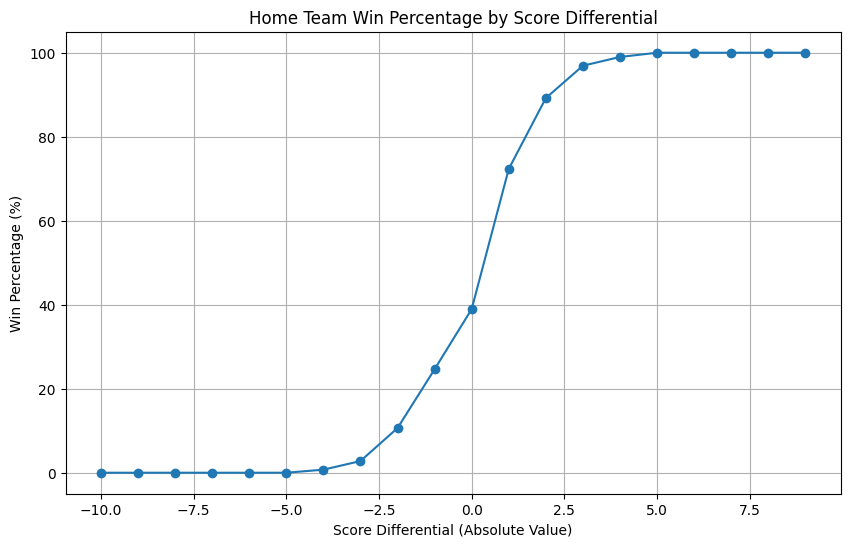

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(score_diff_summary['score_differential'], score_diff_summary['home_win_percentage'], marker='o')
plt.title('Home Team Win Percentage by Score Differential')
plt.xlabel('Score Differential (Absolute Value)')
plt.ylabel('Win Percentage (%)')
plt.grid()
plt.show()


In [21]:
game_plays_data.columns

Index(['eventId', 'timeInPeriod', 'timeRemaining', 'situationCode', 'typeCode',
       'typeDescKey', 'sortOrder', 'period_number', 'period_type',
       'max_regulation_periods', 'team_id', 'details.losingPlayerId',
       'winning_player_id', 'xCoord', 'yCoord', 'zone_code', 'hitter',
       'hittee', 'shot_type', 'shooting_player', 'goalie', 'away_sog',
       'home_sog', 'reason', 'type_code', 'desc_key', 'duration',
       'committed_by', 'player_id', 'blocker', 'drawn_by', 'scoring_player',
       'scoring_player_total', 'assist_1', 'assist1_total', 'assist_2',
       'assist2_total', 'away_score', 'home_score', 'secondary_reason',
       'game_id', 'served_by', 'details.discreteClip', 'homeTeamDefendingSide',
       'periodDescriptor.otPeriods', 'pptReplayUrl',
       'details.highlightClipSharingUrl', 'details.highlightClipSharingUrlFr',
       'details.highlightClip', 'details.highlightClipFr',
       'details.discreteClipFr', 'situation', 'time_in_seconds',
       'goalie_sit

In [30]:
game_plays_data['penalty_expected_duration'] = np.where(game_plays_data['typeDescKey']=="penalty", game_plays_data['time_in_seconds']+game_plays_data['duration_seconds'], np.nan)
game_plays_data.head()

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation,id,awayTeam.id,away_team,homeTeam.id,home_team,score_differential,duration_seconds,home_win,penalty_expected_duration
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN


In [37]:

# Add 'power_play' and 'penalty_kill' columns
game_plays_data['power_play'] = None
game_plays_data['penalty_kill'] = None


KeyboardInterrupt: 

In [39]:


# Iterate through rows where typeDescKey is 'penalty'
for idx, row in game_plays_data[game_plays_data['typeDescKey'] == 'penalty'].iterrows():
    penalty_team = row['team_id']  # Team on penalty kill
    penalty_end = row['penalty_expected_duration']  # End of the penalty duration
    game_time = row['time_in_seconds']  # seconds into the period
    home_team = row['homeTeam.id']
    away_team = row['awayTeam.id']
    
    # Skip if penalty duration is not valid
    if penalty_end is None:
        continue
    
    # Iterate through rows after the penalty row
    for i in range(idx + 1, len(game_plays_data)):
        next_row = game_plays_data.loc[i]
        if penalty_team == home_team:
            game_plays_data.at[i, 'power_play'] = 'away '
            game_plays_data.at[i, 'penalty_kill'] = 'home'
        else:
            game_plays_data.at[i, 'power_play'] = 'home'
            game_plays_data.at[i, 'penalty_kill'] = 'away'      

        # Break the loop if conditions are no longer met
        if next_row['time_in_seconds'] > penalty_end or next_row['typeDescKey'] == 'goal':
            break



game_plays_data.head(25)

,eventId,timeInPeriod,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,max_regulation_periods,team_id,details.losingPlayerId,winning_player_id,xCoord,yCoord,zone_code,hitter,hittee,shot_type,shooting_player,goalie,away_sog,home_sog,reason,type_code,desc_key,duration,committed_by,player_id,blocker,drawn_by,scoring_player,scoring_player_total,assist_1,assist1_total,assist_2,assist2_total,away_score,home_score,secondary_reason,game_id,served_by,details.discreteClip,homeTeamDefendingSide,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr,situation,time_in_seconds,goalie_situation,id,awayTeam.id,away_team,homeTeam.id,home_team,score_differential,duration_seconds,home_win,penalty_expected_duration,power_play,penalty_kill
0,51,00:00,20:00,1551,520,period-start,8,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
1,52,00:00,20:00,1551,502,faceoff,9,1,REG,3,18.0,8471276.0,8475793.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,0,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
2,8,00:56,19:04,1551,503,hit,15,1,REG,3,18.0,NaN,NaN,21.0,35.0,N,8474056.0,8473419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,56,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
3,9,01:04,18:56,1551,503,hit,17,1,REG,3,18.0,NaN,NaN,-30.0,38.0,O,8468486.0,8478075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,64,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
4,53,01:26,18:34,1551,506,shot-on-goal,22,1,REG,3,6.0,NaN,NaN,-6.0,30.0,N,NaN,NaN,wrist,8476891.0,8471469.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,86,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
5,10,01:31,18:29,1551,503,hit,24,1,REG,3,6.0,NaN,NaN,81.0,-36.0,O,8474062.0,8471296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,91,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
6,11,01:45,18:15,1551,503,hit,25,1,REG,3,6.0,NaN,NaN,-32.0,-35.0,D,8477213.0,8476447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,105,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
7,12,01:50,18:10,1551,503,hit,26,1,REG,3,6.0,NaN,NaN,69.0,38.0,O,8478569.0,8476925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,110,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
8,13,01:51,18:09,1551,516,stoppage,27,1,REG,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,icing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,111,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None
9,54,01:51,18:09,1551,502,faceoff,29,1,REG,3,18.0,8477956.0,8476925.0,70.0,-22.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017020005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 on 5,111,in net,2017020005,18,NSH,6,BOS,NaN,NaN,1,NaN,None,None


In [40]:

# Filter data based on relevant conditions
data = game_plays_data[['time_in_seconds', 'score_differential', 'home_win']]
data.head()

,time_in_seconds,score_differential,home_win
0,0,NaN,1
1,0,NaN,1
2,56,NaN,1
3,64,NaN,1
4,86,NaN,1


In [41]:

# Pool together all situations where the score differential is 5 or more
data['score_differential'] = np.where(data['score_differential'] > 5, 5, data['score_differential'])
data['score_differential'] = np.where(data['score_differential'] < -5, -5, data['score_differential'])
data.head()
# Remove rows with missing values
data = data.dropna()


In [42]:
print(data['time_in_seconds'].dtype)


int64


In [43]:
print(data['score_differential'].dtype)
data['score_differential'] = pd.to_numeric(data['score_differential'], errors='coerce')


float64


In [44]:
data.head()

,time_in_seconds,score_differential,home_win
42,517,1.0,1
95,1189,0.0,1
149,348,1.0,1
205,943,2.0,1
318,1027,3.0,1


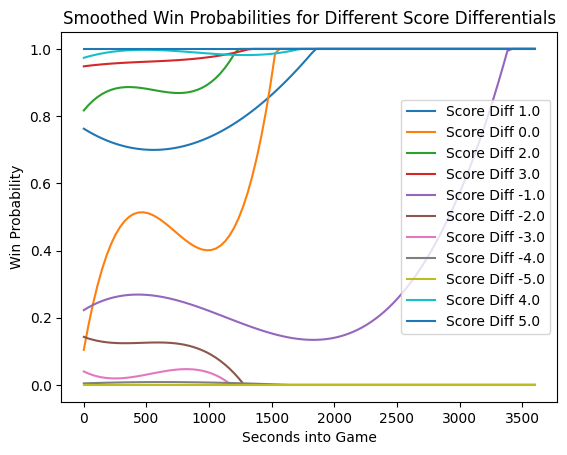

In [49]:
# Ensure score differential maintains its sign (+ or -)
# We now keep positive and negative values for score differential
data['score_differential'] = np.where(data['score_differential'] > 5, 5, data['score_differential'])
data['score_differential'] = np.where(data['score_differential'] < -5, -5, data['score_differential'])

# Remove rows with NaN values in relevant columns
data = data.dropna(subset=['time_in_seconds', 'score_differential', 'home_win'])

# Initialize list to store smoothed results
smoothed_results = []

# Fit OLS models for each unique score differential (keeping sign)
for sd in data['score_differential'].unique():
    subset = data[data['score_differential'] == sd]
    
    # Prepare the independent variables (time, time^2, time^3)
    X = np.column_stack([subset['time_in_seconds'], subset['time_in_seconds']**2, subset['time_in_seconds']**3])
    X = sm.add_constant(X)  # Add intercept to the model
    
    # Remove rows where any value in X is NaN or Inf
    mask = np.isfinite(X).all(axis=1)
    X_cleaned = X[mask]
    y_cleaned = subset['home_win'].iloc[mask]  # Corresponding y values
    
    # Fit the OLS model
    model = sm.OLS(y_cleaned, X_cleaned).fit()
    smoothed_results.append((sd, model.params))
    
    # Generate smoothed values (predictions) for time range 0 to 3600 seconds
    time_values = np.linspace(0, 3600, 100)  # Time from 0 to 3600 seconds
    X_pred = np.column_stack([time_values, time_values**2, time_values**3])
    X_pred = sm.add_constant(X_pred)
    
    # Predicted win probabilities
    smoothed_probs = model.predict(X_pred)
    
    # Clip probabilities to be between 0 and 0.9999
    smoothed_probs = np.clip(smoothed_probs, 0, 0.9999)
    # Inside the loop, before plotting, check the smoothed_probs array
    if smoothed_probs.min() < 0 or smoothed_probs.max() > 1:
        print(f"Problem with score diff {sd}: {smoothed_probs.min()} to {smoothed_probs.max()}")

    # Plot the smoothed curves
    plt.plot(time_values, smoothed_probs, label=f"Score Diff {sd}")

# Add labels and title
plt.title("Smoothed Win Probabilities for Different Score Differentials")
plt.xlabel("Seconds into Game")
plt.ylabel("Win Probability")
plt.legend()
plt.show()


c:\Users\kjcs2\GitHub\hockey\hockey_env\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:               home_win   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -257.3
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               1.00
Time:                        13:07:36   Log-Likelihood:                 15625.
No. Observations:                 776   AIC:                        -3.124e+04
Df Residuals:                     772   BIC:                        -3.122e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   8.25e-11   1.21e+10      0.0

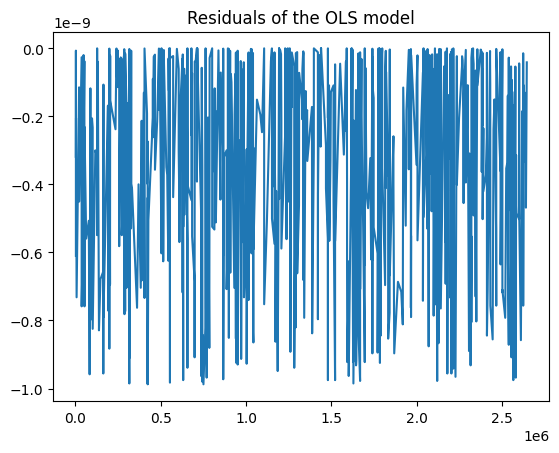

In [50]:
print(model.summary())
residuals = y_cleaned - model.predict(X_cleaned)
plt.plot(residuals)
plt.title('Residuals of the OLS model')
plt.show()


In [51]:
# Combine all smoothed results into a DataFrame
smoothed_df = pd.DataFrame(smoothed_results, columns=['score_differential', 'params'])
smoothed_df.to_csv('smoothed_win_probabilities.csv', index=False)


In [52]:
game_plays_data['pp_goal'] = np.where(game_plays_data['situationCode'])

ValueError: Length of values (1) does not match length of index (2646841)

In [ ]:
def calculate_powerplay_win_probability(data, penalty_info, team_id):
    # Look up powerplay rate for the team and the current penalty situation
    pp_rate = get_powerplay_rate(team_id)  # Historical PP scoring rate
    sh_rate = get_shorthanded_rate(team_id)  # Historical SH scoring rate
    
    # Calculate win probability based on whether the home team is on a powerplay or shorthanded
    if penalty_info['home_team_powerplay']:
        return pp_rate  # Increase probability if on powerplay
    elif penalty_info['away_team_powerplay']:
        return sh_rate  # Decrease probability if on shorthanded
    return 0.5  # No advantage if even strength
